# Dataset Preparation for Prediction of Imminent ICU Admission and Prolonged Stay

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import math
import numpy as np
import pandas as pd
import spacy

import seaborn as sns
sns.set(style = 'darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from pathlib import Path

from utils.splits import set_group_splits
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir'),
 'figdir': PosixPath('../data/workdir/figdir'),
 'raw_csv': PosixPath('../data/raw_dataset.csv'),
 'proc_csv': PosixPath('../data/proc_dataset.csv'),
 'imminent_adm_cols': ['hadm_id', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'prolonged_stay_label'],
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime'],
 'dates': ['charttime', 'intime'],
 'ia_thresh': {'lr': 0.5, 'rf': 0.32, 'gbm': 0.52},
 'ps_thresh': {'lr': 0.47, 'rf': 0.35, 'gbm': 0.45}}

## Stats

In [3]:
df = pd.read_csv(args.proc_csv)
print(df.columns)
print(df.shape)

ia_df = df.loc[(df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = df[args.prolonged_stay_cols].copy()

Index(['subject_id', 'hadm_id', 'icustay_id', 'admission_type', 'admittime',
       'dischtime', 'intime', 'outtime', 'charttime', 'icu_los', 'deathtime',
       'adm_to_icu_period', 'charttime_to_icu_period', 'chartinterval',
       'ethnicity', 'dob', 'gender', 'admission_age', 'category',
       'imminent_adm_label', 'prolonged_stay_label', 'note', 'processed_note'],
      dtype='object')
(75271, 23)


In [4]:
df['subject_id'].nunique(), df['hadm_id'].nunique()

(11840, 12877)

In [6]:
ages = df.groupby(['subject_id'])[['admission_age']].first().to_numpy().reshape(-1)
ages[ages>100] = 100
print(f"Median age: {ages.mean():0.1f}")
print(f"IQR: {np.percentile(ages, 25):0.1f} - {np.percentile(ages, 75):0.1f}")

Median age: 65.7
IQR: 55.1 - 77.6


In [7]:
df['adm_to_icu_period'].describe().reset_index()

,index,adm_to_icu_period
0,count,75271.000000
1,mean,14.277002
2,std,16.132856
3,min,0.000000
4,25%,4.230000
5,50%,9.710000
6,75%,17.860000
7,max,141.290000


In [8]:
df.groupby(df['admission_type'])['hadm_id'].nunique().reset_index()

,admission_type,hadm_id
0,ELECTIVE,2425
1,EMERGENCY,9995
2,URGENT,457


In [9]:
df.groupby(df['ethnicity'])['subject_id'].nunique().reset_index()

,ethnicity,subject_id
0,asian,283
1,black,778
2,hispanic,377
3,unknown,1791
4,white,8634


Make sure average prevalence of random test sets is approximately same as real prevalence

In [ ]:
ia_p = []
ps_p = []

for seed in range(127, 227):
  sdf = set_group_splits(ia_df.copy(), group_col='hadm_id', seed=seed)
  test_size = len(sdf.loc[(sdf['split'] == 'test')])
  test_pos = len(sdf.loc[(sdf['split'] == 'test') & (sdf['imminent_adm_label'] == 1)])
  ia_p.append(test_pos/test_size)  
  
  sdf = set_group_splits(ps_df.copy(), group_col='hadm_id', seed=seed)
  test_size = len(sdf.loc[(sdf['split'] == 'test')])
  test_pos = len(sdf.loc[(sdf['split'] == 'test') & (sdf['prolonged_stay_label'] == 1)])
  ps_p.append(test_pos/test_size)  
  

ia_p = np.array(ia_p)
ps_p = np.array(ps_p)

print(f"Prevalence of Imminent Admission: {(len(ia_df.loc[ia_df['imminent_adm_label'] == 1])/len(ia_df)):0.3f}")
print(f"Average of test set = {(ia_p.mean()):0.3f}, std = {(ia_p.std()):0.3f}")
print(f"Prevalence of Prolonged Stay: {(len(ps_df.loc[ps_df['prolonged_stay_label'] == 1])/len(ps_df)):0.3f}")
print(f"Average of test set = {(ps_p.mean()):0.3f}, std = {(ps_p.std()):0.3f}")

In [10]:
print(f"Average number of notes per admission for imminent admission: {ia_df.groupby('hadm_id').size().mean():0.2f}")
print(f"Average number of notes per admission for prolonged stay (and entire dataset): {ps_df.groupby('hadm_id').size().mean():0.2f}")

Average number of notes per admission for imminent admission: 7.34
Average number of notes per admission for prolonged stay (and entire dataset): 5.85


In [11]:
df.groupby(df['deathtime'].apply(lambda x: True if pd.notnull(x) else False))['subject_id'].nunique().reset_index()

,deathtime,subject_id
0,False,10367
1,True,1628


In [12]:
df.groupby(df['gender'])['subject_id'].nunique().reset_index()

,gender,subject_id
0,F,5085
1,M,6755


Distribution of notes by category

In [13]:
df.groupby(df['category']).size().reset_index()

,category,0
0,Case Management,28
1,Consult,5
2,General,285
3,Nursing,8831
4,Nursing/other,15523
5,Nutrition,433
6,Pharmacy,6
7,Physician,4109
8,Radiology,44526
9,Rehab Services,222


Distribution of notes by category for imminent admissions and delayed admissions

In [ ]:
df.loc[(df['imminent_adm_label'] == 1)].groupby('category').size().reset_index()

In [ ]:
df.loc[(df['imminent_adm_label'] == 0)].groupby('category').size().reset_index()

Distribution of notes for prolonged stay and short stay

In [ ]:
df.loc[(df['prolonged_stay_label'] == 1)].groupby('category').size().reset_index()

In [ ]:
df.loc[(df['prolonged_stay_label'] == 0)].groupby('category').size().reset_index()

In [14]:
df['icu_los'].describe().reset_index()

,index,icu_los
0,count,75271.000000
1,mean,5.828632
2,std,12.589301
3,min,0.000100
4,25%,1.577300
5,50%,2.941900
6,75%,5.886600
7,max,173.072500


In [16]:
df['note'].apply(len).describe().reset_index()

,index,note
0,count,75271.000000
1,mean,1896.546665
2,std,1572.983636
3,min,121.000000
4,25%,1024.000000
5,50%,1361.000000
6,75%,2095.000000
7,max,8545.000000


In [ ]:
df['charttime_to_icu_period'].describe().reset_index()

## Plots

In [ ]:
df = pd.read_csv(args.proc_csv)
df.columns

In [ ]:
intervals = ['-1 ≤ t ≤ 0']
intervals += [f'-{i+1} ≤ t ≤ -{i}' for i in range(1, 15)]
intervals.append('t ≤ -15')

### Bar Plot of Notes Over Days

#### All Notes

In [ ]:
plot_df = pd.DataFrame(df.groupby(['chartinterval']).size(), columns=['n_notes'])
plot_df.reset_index(inplace=True, drop=True)
plot_df['days'] = intervals

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='days', y='n_notes', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_xlabel('Time to ICU Admission (days)')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
    ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'note_bp.tif', dpi=300)

#### By Category

In [ ]:
def plot_intervals(ax, df, cat):
  sns.barplot(x='days', y='n_notes', data=df, ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(f"Note Category: {cat}\n# notes: {df['n_notes'].sum()}")   

  for index, (_, row) in enumerate(df.iterrows()):
      ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')    

In [ ]:
plot_df = pd.DataFrame(df.groupby(['category', 'chartinterval']).size(), columns=['n_notes'])
plot_df.reset_index(inplace=True)
plot_df['days'] = plot_df['chartinterval'].apply(lambda x: intervals[x])
plot_df.drop(['chartinterval'], inplace=True, axis=1)

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(20, 50))
plot_intervals(ax[0][0], plot_df.loc[plot_df['category'] == 'Case Management ', ['n_notes', 'days']], 'Case Management')
plot_intervals(ax[0][1], plot_df.loc[plot_df['category'] == 'Consult', ['n_notes', 'days']], 'Consult')

plot_intervals(ax[1][0], plot_df.loc[plot_df['category'] == 'General', ['n_notes', 'days']], 'General')
plot_intervals(ax[1][1], plot_df.loc[plot_df['category'] == 'Nursing', ['n_notes', 'days']], 'Nursing')

plot_intervals(ax[2][0], plot_df.loc[plot_df['category'] == 'Nursing/other', ['n_notes', 'days']], 'Nursing/other')
plot_intervals(ax[2][1], plot_df.loc[plot_df['category'] == 'Nutrition', ['n_notes', 'days']], 'Nutrition')

plot_intervals(ax[3][0], plot_df.loc[plot_df['category'] == 'Pharmacy', ['n_notes', 'days']], 'Pharmacy')
plot_intervals(ax[3][1], plot_df.loc[plot_df['category'] == 'Physician ', ['n_notes', 'days',]], 'Physician')

plot_intervals(ax[4][0], plot_df.loc[plot_df['category'] == 'Radiology', ['n_notes', 'days']], 'Radiology')
plot_intervals(ax[4][1], plot_df.loc[plot_df['category'] == 'Rehab Services', ['n_notes', 'days']], 'Rehab Services')

plot_intervals(ax[5][0], plot_df.loc[plot_df['category'] == 'Respiratory ', ['n_notes', 'days']], 'Respiratory')
plot_intervals(ax[5][1], plot_df.loc[plot_df['category'] == 'Social Work', ['n_notes', 'days']], 'Social Work')

fig.text(0.5, 0.1, 'Time to ICU Admission (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.3)

In [ ]:
# cats = sorted(list(df['category'].unique()))

# n = 0
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# plot_intervals(ax, plot_df.loc[plot_df['category'] == cats[n], ['n_notes', 'days']], cats[n])
# ax.set_xlabel('Time to ICU Admission (days)')
# ax.set_ylabel('# notes')

In [ ]:
# fig.savefig(args.figdir/'note_cats_bp.tif', dpi=300)

### Note Chart Time to ICU Admission Period Histogram

#### All Notes

In [ ]:
plot_df = df[['category', 'charttime_to_icu_period']]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df['charttime_to_icu_period'], kde=False, ax=ax, bins=80)
ax.set_xlabel('Period between Note Chart Time and ICU Admission Time (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 60)

# ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {mdf['chart_icu_period'].min()}, Avg: {mdf['chart_icu_period'].mean(): 0.2f}, Max: {mdf['chart_icu_period'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'note_icu_period_hist.tif', dpi=300)

#### By Category

In [ ]:
def plot_period(ax, df, cat):
  sns.distplot(df, kde=False, ax=ax, bins=10)
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(f"Note Category: {cat}")   

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(20, 50))
plot_period(ax[0][0], plot_df.loc[plot_df['category'] == 'Case Management ', ['charttime_to_icu_period']], 'Case Management')
plot_period(ax[0][1], plot_df.loc[plot_df['category'] == 'Consult', ['charttime_to_icu_period']], 'Consult')

plot_period(ax[1][0], plot_df.loc[plot_df['category'] == 'General', ['charttime_to_icu_period']], 'General')
plot_period(ax[1][1], plot_df.loc[plot_df['category'] == 'Nursing', ['charttime_to_icu_period']], 'Nursing')

plot_period(ax[2][0], plot_df.loc[plot_df['category'] == 'Nursing/other', ['charttime_to_icu_period']], 'Nursing/other')
plot_period(ax[2][1], plot_df.loc[plot_df['category'] == 'Nutrition', ['charttime_to_icu_period']], 'Nutrition')

plot_period(ax[3][0], plot_df.loc[plot_df['category'] == 'Pharmacy', ['charttime_to_icu_period']], 'Pharmacy')
plot_period(ax[3][1], plot_df.loc[plot_df['category'] == 'Physician ', ['charttime_to_icu_period',]], 'Physician')

plot_period(ax[4][0], plot_df.loc[plot_df['category'] == 'Radiology', ['charttime_to_icu_period']], 'Radiology')
plot_period(ax[4][1], plot_df.loc[plot_df['category'] == 'Rehab Services', ['charttime_to_icu_period']], 'Rehab Services')

plot_period(ax[5][0], plot_df.loc[plot_df['category'] == 'Respiratory ', ['charttime_to_icu_period']], 'Respiratory')
plot_period(ax[5][1], plot_df.loc[plot_df['category'] == 'Social Work', ['charttime_to_icu_period']], 'Social Work')

fig.text(0.5, 0.11, 'Period between Note Chart Time and ICU Admission Time (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.1)

In [ ]:
# cats = sorted(list(df['category'].unique()))

# n = 0
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# plot_period(ax, plot_df.loc[plot_df['category'] == cats[n], ['chart_icu_period']], cats[n])
# ax.set_xlabel('Time to ICU Admission (days)')
# ax.set_ylabel('# notes')

In [ ]:
# fig.savefig(args.figdir/'note_cat_icu_period_hist.tif', dpi=300)

### Hospital Admission to ICU Admission Period Histogram

In [ ]:
plot_df = df[['adm_to_icu_period']]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df, kde=False, ax=ax, bins=80)
ax.set_xlabel('Time between hospital admission and ICU admission (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 70)
# ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {mdf['adm_icu_period'].min()}, Avg: {mdf['adm_icu_period'].mean(): 0.2f}, Max: {mdf['adm_icu_period'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')    

In [ ]:
# fig.savefig(args.figdir/'adm_icu_period_hist.tif', dpi=300)

### Note Length Histogram

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['note'].apply(len), kde=False, ax=ax, bins=100)
ax.set_xlabel('Length of Note (characters)')
ax.set_ylabel('# notes')

In [ ]:
# fig.savefig(args.figdir/'note_len_hist.tif', dpi=300)

### Imminent ICU Prediction Class Distribution

In [20]:
desc = ['Unused', 'Delayed Admission', 'Imminent Admission']

#### Without Admissions

In [21]:
plot_df = pd.DataFrame(df.groupby(['imminent_adm_label']).size(), columns=['n_notes']).reset_index()
plot_df['imminent_adm_label'] = desc
plot_df = plot_df.reindex([2, 1, 0])
plot_df.reset_index(inplace=True, drop=True)

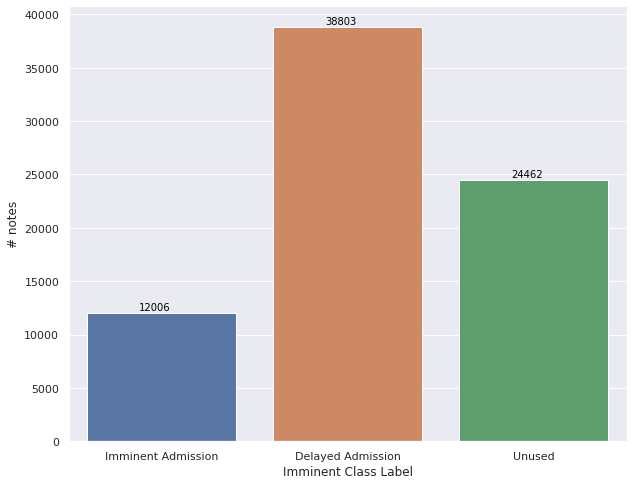

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='imminent_adm_label', y='n_notes', data=plot_df, ax=ax)
ax.set_xlabel('Imminent Class Label')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
  ax.text(index+0.05, row['n_notes']+50, str(row['n_notes']), color='black', ha='right', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'imminent_label_bp.tif', dpi=300)

#### With Admissions

In [26]:
p1 = pd.DataFrame(df.groupby(['imminent_adm_label']).size(), columns=['n_notes']).reset_index()
p2 = df.groupby(['imminent_adm_label'])['hadm_id'].nunique().reset_index()
p = p1.merge(p2, on=['imminent_adm_label'])

In [27]:
p['imminent_adm_label'] = desc

In [28]:
p = p.reindex([2,1,0])
p.reset_index(inplace=True, drop=True)
p

,imminent_adm_label,n_notes,hadm_id
0,Imminent Admission,12006,5523
1,Delayed Admission,38803,3009
2,Unused,24462,10598


In [30]:
plot_df = p.copy()
plot_df.rename(columns={'hadm_id':'# Admissions', 'n_notes':'# Notes'}, inplace=True)
plot_df = pd.melt(plot_df, id_vars='imminent_adm_label', var_name='Legend', value_name='counts')

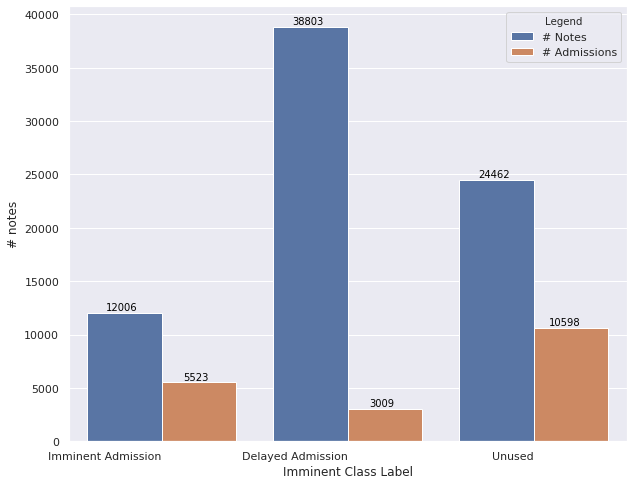

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='imminent_adm_label', y='counts', hue='Legend', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.set_xlabel('Imminent Class Label')
ax.set_ylabel('# notes')

for index, row in plot_df.iterrows():
    if index < len(plot_df)//2:
        ax.text(index-0.13, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom')
    else:
        ax.text(index % (len(plot_df)//2)+0.25, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'imminent_label_adms_bp.tif', dpi=300)

### Prolonged Stay Class Distribution

In [32]:
desc = ['Short Stay', 'Prolonged Stay']

#### Without Admissions

In [33]:
plot_df = pd.DataFrame(df.groupby(['prolonged_stay_label']).size(), columns=['n_notes']).reset_index()
plot_df['prolonged_stay_label'] = desc
plot_df = plot_df.reindex([1, 0])
plot_df.reset_index(inplace=True, drop=True)
plot_df

,prolonged_stay_label,n_notes
0,Prolonged Stay,27562
1,Short Stay,47709


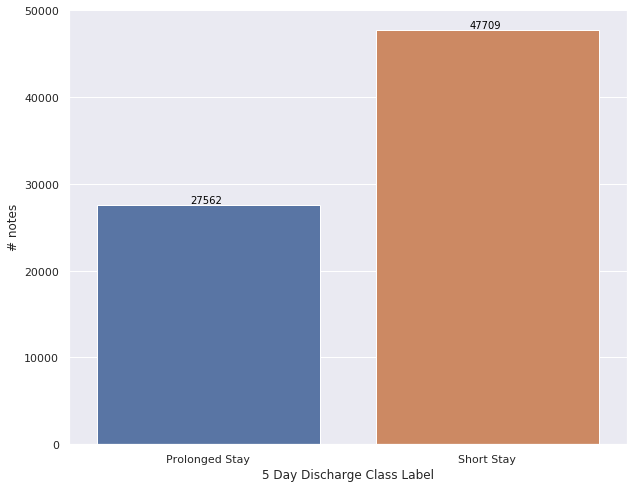

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='prolonged_stay_label', y='n_notes', data=plot_df, ax=ax)
ax.set_xlabel('5 Day Discharge Class Label')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
  ax.text(index+0.05, row['n_notes']+50, str(row['n_notes']), color='black', ha='right', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'discharge_label_bp.tif', dpi=300)

#### With Admissions

In [35]:
p1 = pd.DataFrame(df.groupby(['prolonged_stay_label']).size(), columns=['n_notes']).reset_index()
p2 = df.groupby(['prolonged_stay_label'])['hadm_id'].nunique().reset_index()
p = p1.merge(p2, on=['prolonged_stay_label'])
p['prolonged_stay_label'] = desc
p = p.reindex([1,0])
p.reset_index(inplace=True, drop=True)
p

,prolonged_stay_label,n_notes,hadm_id
0,Prolonged Stay,27562,3575
1,Short Stay,47709,9302


In [36]:
plot_df = p.copy()
plot_df.rename(columns={'hadm_id':'# Admissions', 'n_notes':'# Notes'}, inplace=True)
plot_df = pd.melt(plot_df, id_vars='prolonged_stay_label', var_name='Legend', value_name='counts')

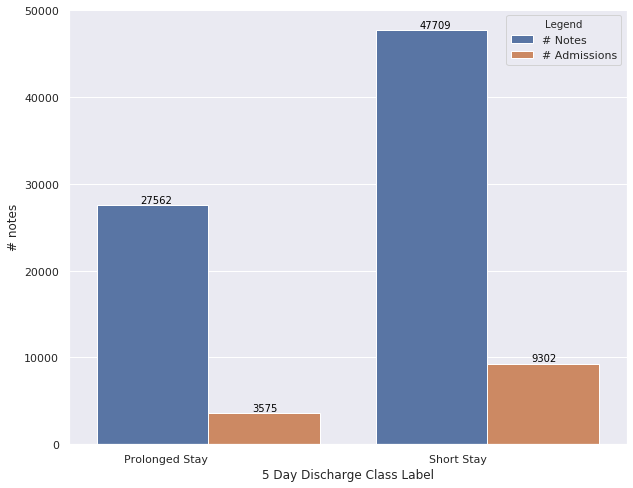

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='prolonged_stay_label', y='counts', hue='Legend', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.set_xlabel('5 Day Discharge Class Label')
ax.set_ylabel('# notes')

for index, row in plot_df.iterrows():
    if index < len(plot_df)//2:
        ax.text(index-0.13, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom')
    else:
        ax.text(index % (len(plot_df)//2)+0.25, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'discharge_label_adms_bp.tif', dpi=300)